In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# to work with rasters
# https://rasterio.readthedocs.io/en/latest/quickstart.html#opening-a-dataset-in-reading-mode
import rasterio as rio
from rasterio.plot import show
from rasterio.features import shapes

import cv2

from shapely.geometry import Polygon
from shapely.affinity  import affine_transform
import geopandas as gpd

In [2]:
# *** EXTRACT POLYGONS FROM REGIONS ***

# ------------------------------------------------------------------

# shape is a single JSON-ish polygon coming from the rasterio.features.shapes function
# rasterio.features.shapes returns a list of pairs (shape, value), example of a pair:
#   ({'type': 'Polygon', 'coordinates': [[(6,0),(6,2),(8,0),(6,0)]]}, 1.0)
#   shape is the first entry (the dictionary)
def create_polygon(shape):
    
    poly_list = shape.get('coordinates')

    if len(poly_list) == 1:    # polygon without holes
        return(Polygon(poly_list[0]))

    holes = []
    for i in range(1,len(poly_list)):
        holes.append(poly_list[i])
    return Polygon(shell=poly_list[0], holes=holes)

# ------------------------------------------------------------------

# shapes list is the output from rasterio.features.shapes 
# crs will be assigned to the GeoDataFrame
def shapes_2_GeoDataFrame(shapes_list, crs = False):

    df = gpd.GeoDataFrame() 
    i = 0
    for shape, value in shapes_list:
        df.loc[i,'geometry'] =create_polygon(shape)
        i = i+1

    if(crs != False):
        df.crs = crs
    
    return df
    

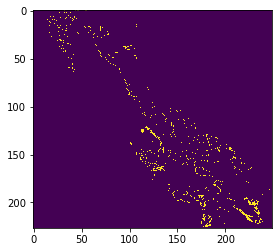

In [5]:
temp8 = rio.open('ca_clim_regions_2008.tif')
temp19 = rio.open('ca_clim_regions_2019.tif')

hotter = temp19.read(1) -  temp8.read(1)
hotter = np.where(hotter>0,1,hotter)
hotter = np.where(hotter<1,0,hotter) 

show(hotter)

In [ ]:
# for i in range(2,10):
#     print(i)
#     show(cv2.dilate(hotter, np.ones((i,i), np.uint8), iterations=1))

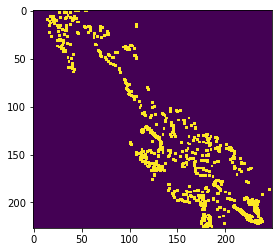

In [10]:
thick_regions = cv2.dilate(hotter, np.ones((3,3), np.uint8), iterations=1)
thick_regions = thick_regions.astype('uint8')  
show(thick_regions)

In [11]:
# shapes_list is type generator: iterable once
thick_shps = shapes(source = thick_regions, 
                     mask= thick_regions,   # include this so regions with value 0 are not inclduded
                     connectivity = 8,
                     transform = temp8.transform)

aff_data = shapes_2_GeoDataFrame(thick_shps , temp8.crs)
aff_data

,geometry
0,"POLYGON ((-122.70833 42.00000, -122.70833 41.9..."
1,"POLYGON ((-122.29167 42.00000, -122.29167 41.9..."
2,"POLYGON ((-123.41667 41.95833, -123.41667 41.8..."
3,"POLYGON ((-123.37500 41.75000, -123.37500 41.6..."
4,"POLYGON ((-123.20833 42.00000, -123.08333 42.0..."
...,...
114,"POLYGON ((-116.29167 33.12500, -116.29167 33.0..."
115,"POLYGON ((-116.45833 33.08333, -116.45833 32.9..."
116,"POLYGON ((-115.29167 33.91667, -115.16667 33.9..."
117,"POLYGON ((-117.16667 33.20833, -117.00000 33.2..."


In [15]:
outfp = "/home/galaz-garcia/python/hotter_regions.shp"
aff_data.to_file(outfp)

'/home/galaz-garcia/python'